In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import urllib.request
import http.cookiejar
from skyfield.sgp4lib import EarthSatellite
import skyfield.api
import datetime

c = 299792458
carrier_freq = 10489.8e6
uplink_freq = 2400.3e6
uplink_relative_doppler = uplink_freq / carrier_freq

In [2]:
def new_figure():
    plt.figure(figsize = (14, 10), facecolor='w')

def set_axis_options():
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.grid()

def set_axis_labels():
    plt.xlabel('UTC time')
    plt.ylabel('Doppler (ppb)')

def set_legend():
    plt.legend([f'EA4GPZ measurements of QO-100 BPSK beacon',\
            'TLEs'])

In [3]:
def opener_spacetrack(username, password):
    # todo: clean login info from ipynb file
    cj = http.cookiejar.CookieJar()
    opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cj))
    auth_url = 'https://www.space-track.org/ajaxauth/login/'
    auth_data = urllib.parse.urlencode({'identity' : username, 'password' : password}).encode('utf-8')
    auth_req = urllib.request.Request(auth_url, auth_data)
    r = opener.open(auth_req)
    return opener

def get_tles(opener):
    url = 'https://www.space-track.org/basicspacedata/query/class/tle/EPOCH/%3E2019-03-08/NORAD_CAT_ID/43700/orderby/EPOCH%20ASC/format/tle'
    r = opener.open(url)
    tle_lines = r.read().decode('ascii').split('\r\n')
    return [EarthSatellite(*x) for x in zip(tle_lines[::2], tle_lines[1::2])]

In [4]:
with open('../spacetrack_auth', 'r') as f:
    username, password = f.read().split('\n')[:2]
    opener = opener_spacetrack(username, password)

tles = get_tles(opener)

In [5]:
ts = skyfield.api.load.timescale()

[#################################] 100% deltat.data


In [6]:
def open_freqdata(path):
    start_timestamp = np.datetime64(path.strip('.f32').split('_')[-1])
    data = np.fromfile(path, dtype = 'float32')
    timestamps = start_timestamp + np.arange(data.size) * np.timedelta64(1, 's')
    return xr.Dataset({'ppb' : (['time'], data/carrier_freq * 1e9)}, coords = {'time' : timestamps})

In [7]:
paths = ['/home/daniel/eshail2_bpsk_freq_2019-03-10T18:14:02.434216.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-11T20:03:48.036492.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-11T22:05:26.024663.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-13T21:57:58.867979.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-13T22:58:18.389283.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-16T18:48:45.105610.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-16T21:56:18.294104.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-18T18:36:18.622041.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-19T19:24:01.045046.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-23T12:29:28.005599.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-25T17:12:51.389787.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-03-28T18:48:59.754530.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-04-01T16:31:15.167054.f32',
         '/home/daniel/eshail2_bpsk_freq_2019-04-07T17:54:41.448196.f32']
cw_paths = ['/home/daniel/eshail2_cw_freq_2019-03-19T19:24:01.045046.f32',
           '/home/daniel/eshail2_cw_freq_2019-03-23T12:29:28.005599.f32',
           '/home/daniel/eshail2_cw_freq_2019-03-25T17:12:51.389787.f32',
           '/home/daniel/eshail2_cw_freq_2019-03-28T18:48:59.754530.f32',
           '/home/daniel/eshail2_cw_freq_2019-04-01T16:31:15.167054.f32',
           '/home/daniel/eshail2_cw_freq_2019-04-07T17:54:41.448196.f32']
bpsk_beacon = xr.merge([open_freqdata(path) for path in paths])
cw_beacon = xr.merge([open_freqdata(path) for path in cw_paths])

times_inactive = [('2019-03-23T10:00','2019-03-23T14:30'), ('2019-03-22T14:00','2019-03-22T14:00'),\
                  ('2019-03-22T18:30','2019-03-22T21:00'), ('2019-03-26T13:00', '2019-03-26T19:00')]

for a, b in times_inactive:
    for d in [bpsk_beacon, cw_beacon]:
        t = d.coords['time']
        d['ppb'][(t >= np.datetime64(a)) & (t <= np.datetime64(b))] = np.nan

/home/daniel/.local/lib64/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/daniel/.local/lib64/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


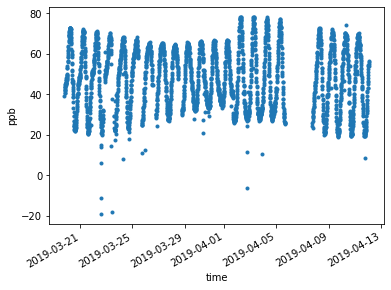

In [8]:
(cw_beacon['ppb'].resample(time = '10min').mean()*carrier_freq*1e-9).plot(linestyle = ' ', marker = '.')

Text(0.5, 1.0, 'BPSK frequency - 250kHz - CW frequency')

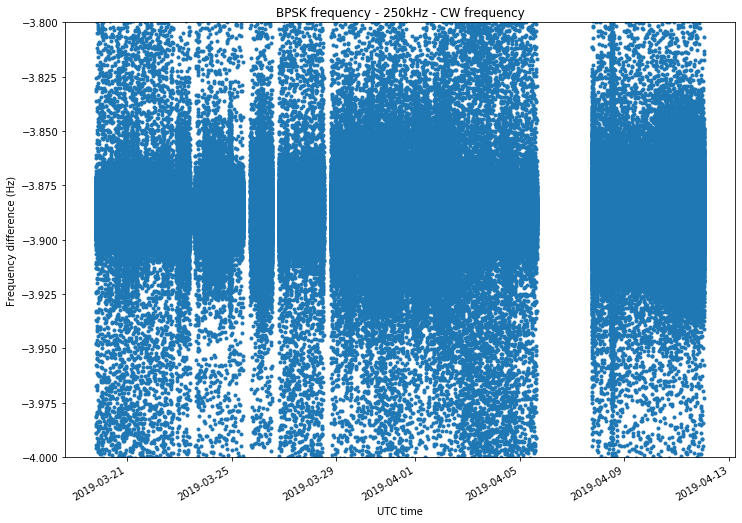

In [9]:
plt.figure(figsize = (12,8), facecolor='w')
beacon_diff = ((bpsk_beacon-cw_beacon)*carrier_freq*1e-9)['ppb']
beacon_diff.plot(linestyle = ' ', marker = '.')
plt.ylim((-4,-3.8))
plt.xlabel('UTC time')
plt.ylabel('Frequency difference (Hz)')
plt.title('BPSK frequency - 250kHz - CW frequency')

In [10]:
beacon_diff[(beacon_diff > -4) & (beacon_diff < -3.8)].mean()

<xarray.DataArray 'ppb' ()>
array(-3.887188, dtype=float32)

(-15560, -15540)

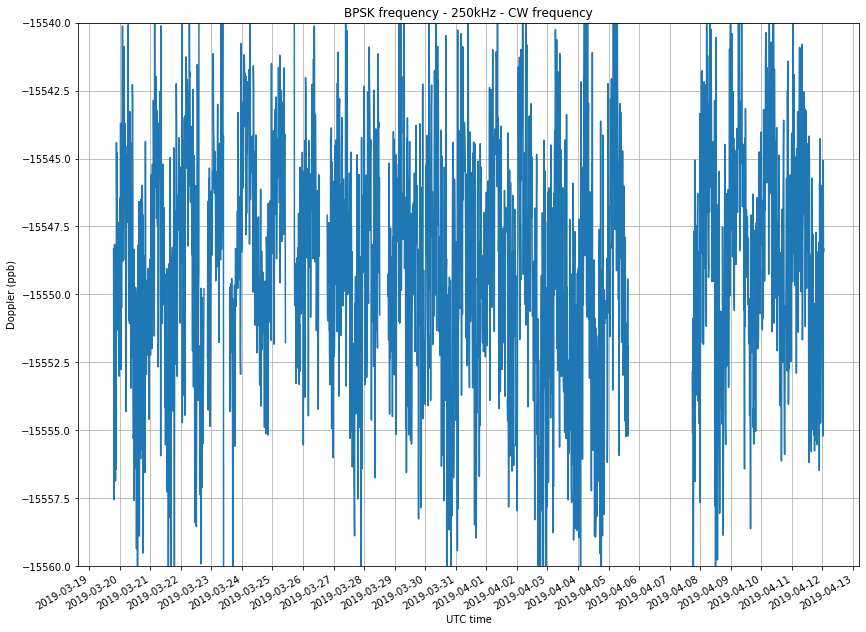

In [11]:
new_figure()
(beacon_diff[(beacon_diff > -4) & (beacon_diff < -3.8)].resample(time = '15min').mean()/250e3*1e9).plot()
set_axis_options()
plt.title('BPSK frequency - 250kHz - CW frequency')
set_axis_labels()
plt.ylim([-15560,-15540])

In [12]:
bpsk_beacon['ppb'][bpsk_beacon['ppb'] < -2] = np.nan
bpsk_beacon['ppb'][bpsk_beacon['ppb'] > 9] = np.nan

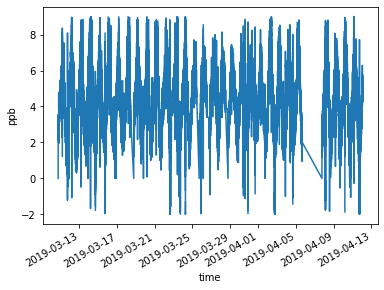

In [13]:
bpsk_beacon['ppb'].plot()

In [14]:
bpsk_beacon['ppb'].mean() * 1e-9 * carrier_freq

<xarray.DataArray 'ppb' ()>
array(44.47268303)

/home/daniel/.local/lib64/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


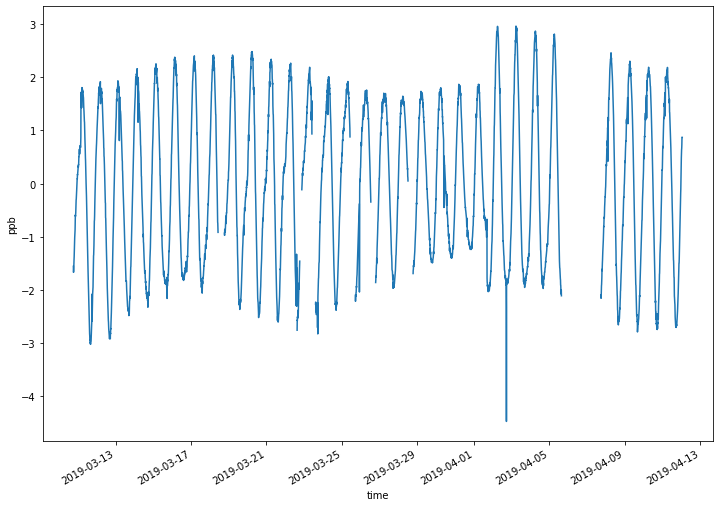

In [15]:
plt.figure(figsize = (12,8) , facecolor='w')
measurements = bpsk_beacon['ppb'].resample(time = '10min').mean()
measurements = measurements - measurements.mean()
measurements.plot()

In [16]:
doppler_times = np.arange(bpsk_beacon.coords['time'].values[0], bpsk_beacon.coords['time'].values[-1], np.timedelta64(1, 'm'))
timestamps = (doppler_times - np.datetime64('1970-01-01T00:00:00'))/np.timedelta64(1, 's')
times = ts.utc([datetime.datetime.utcfromtimestamp(t).replace(tzinfo = skyfield.api.utc) for t in timestamps])

In [17]:
cuts = [None] * (len(tles)+1)
cuts[0] = 0
for j in range(len(tles) - 1):
    try:
        cut = np.where(np.abs(times-tles[j].epoch) - np.abs(times-tles[j+1].epoch) > 0)[0][0]
    except IndexError:
        cut = 0
    cuts[j+1] = max(cut, cuts[j])
slices = [slice(a,b) for a,b in zip(cuts[:-1], cuts[1:])]

In [18]:
ea4gpz = skyfield.api.Topos(latitude = 40.595865, longitude = -3.699069, elevation_m = 800)
qatar = skyfield.api.Topos(latitude = 25.779579, longitude = 51.211864, elevation_m = 0)
bochum = skyfield.api.Topos(latitude = 51.426988, longitude = 7.192558, elevation_m = 0)

In [19]:
rvs_down = [(eshail2 - ea4gpz).at(times[sl]) for eshail2,sl in zip(tles, slices) if len(times[sl])]
rvs_up = [(eshail2 - bochum).at(times[sl]) for eshail2,sl in zip(tles, slices) if len(times[sl])]

In [20]:
dtimes = np.concatenate([doppler_times[sl][:-1] for eshail2,sl in zip(tles, slices) if len(times[sl])])

In [21]:
doppler_data_down = -np.concatenate([np.diff(rv.distance().km) for rv in rvs_down])/60*1e12/c
doppler_data_up = -np.concatenate([np.diff(rv.distance().km) for rv in rvs_up])/60*1e12/c*uplink_relative_doppler
doppler_ppb = xr.Dataset({'up' : (['time'], doppler_data_up), 'down' : (['time'], doppler_data_down)},\
                           coords = {'time' : dtimes})

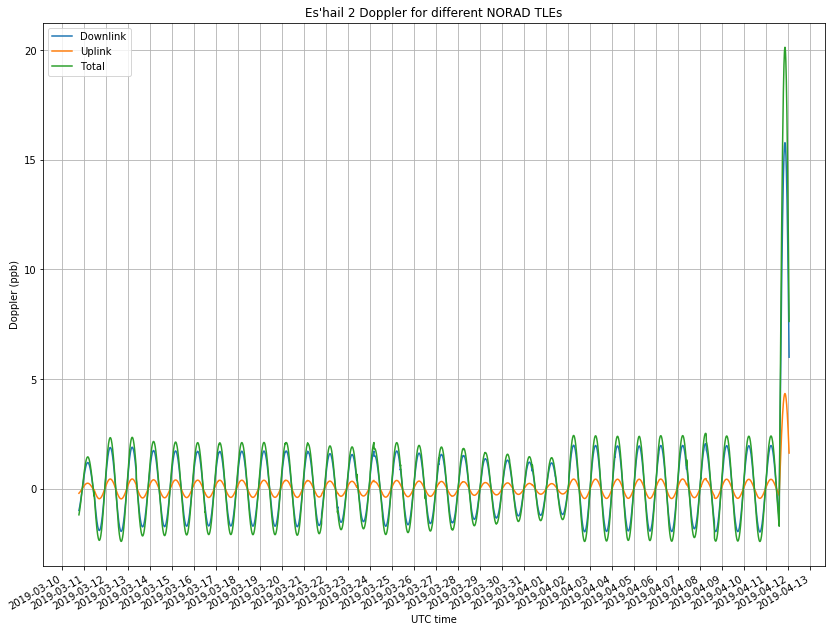

In [22]:
new_figure()
doppler_ppb['down'].plot()
doppler_ppb['up'].plot()
doppler_total = doppler_ppb['up'] + doppler_ppb['down']
doppler_total.plot()
set_axis_options()
plt.title('Es\'hail 2 Doppler for different NORAD TLEs')
set_axis_labels()
plt.legend(['Downlink', 'Uplink', 'Total'])

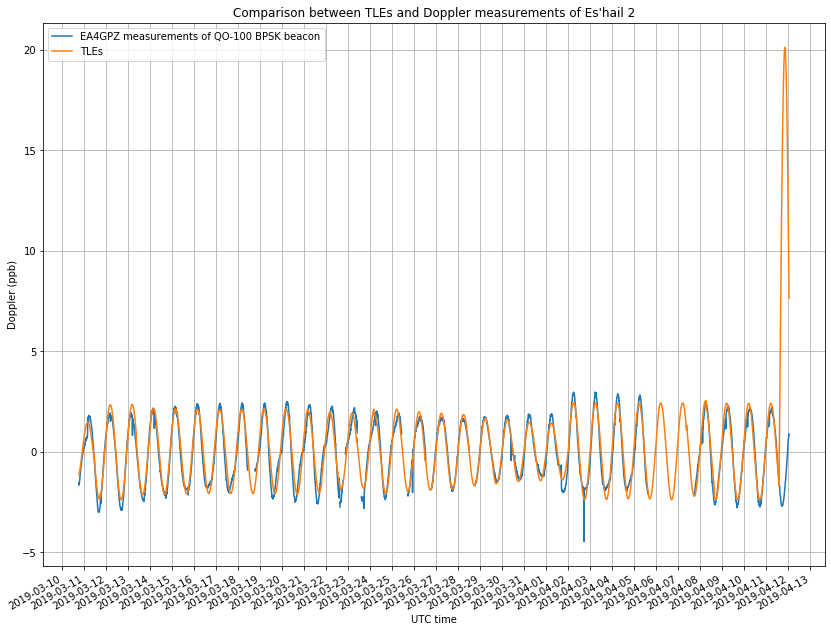

In [23]:
new_figure()
measurements.plot()
doppler_total.plot()
set_axis_options()
set_legend()
set_axis_labels()
plt.title('Comparison between TLEs and Doppler measurements of Es\'hail 2');

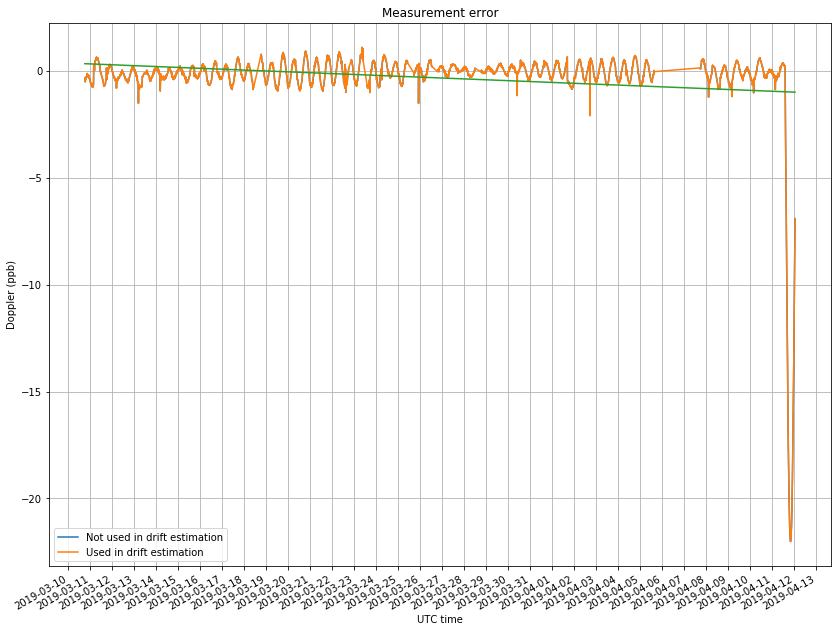

In [24]:
new_figure()
error = (measurements-doppler_total.interp(time = measurements.coords['time'], kwargs = {'fill_value' : 'extrapolate'}))
#error_sel = xr.concat((error.sel(time = slice('2018-11-28 21:00', '2018-12-02 20:44:16')),
#                       error.sel(time = slice('2018-12-08 00:00', '2018-12-09 23:56:04'))),
#                      dim = 'time')
error_sel = error.dropna('time')

error_times = error.coords['time'].values.astype('datetime64[s]').astype('float')
error_times_sel = error_sel.coords['time'].values.astype('datetime64[s]').astype('float')
p_error = np.polyfit(error_times_sel, error_sel.values, 1)
error_model = xr.DataArray(np.polyval(p_error, error_times),
                           coords = {'time' : measurements.coords['time']},
                           dims = ('time'))

error.plot()
error_sel.plot()
error_model.plot()
set_axis_options()
set_axis_labels()
plt.title('Measurement error')
plt.legend(['Not used in drift estimation', 'Used in drift estimation']);

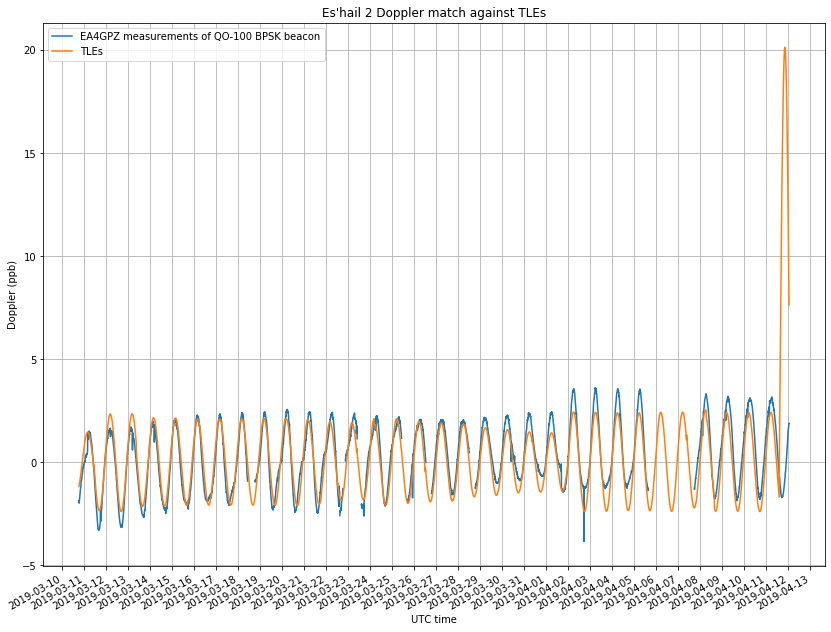

In [25]:
new_figure()
(measurements - error_model).plot()
doppler_total.plot()
set_axis_options()
set_axis_labels()
set_legend()
plt.title('Es\'hail 2 Doppler match against TLEs');

In [26]:
subpoints = [eshail2.at(times[sl]).subpoint() for eshail2,sl in zip(tles,slices) if len(times[sl])]
longitude = np.concatenate([sp.longitude.degrees for sp in subpoints])
latitude = np.concatenate([sp.latitude.degrees for sp in subpoints])
elevation = np.concatenate([sp.elevation.km for sp in subpoints])

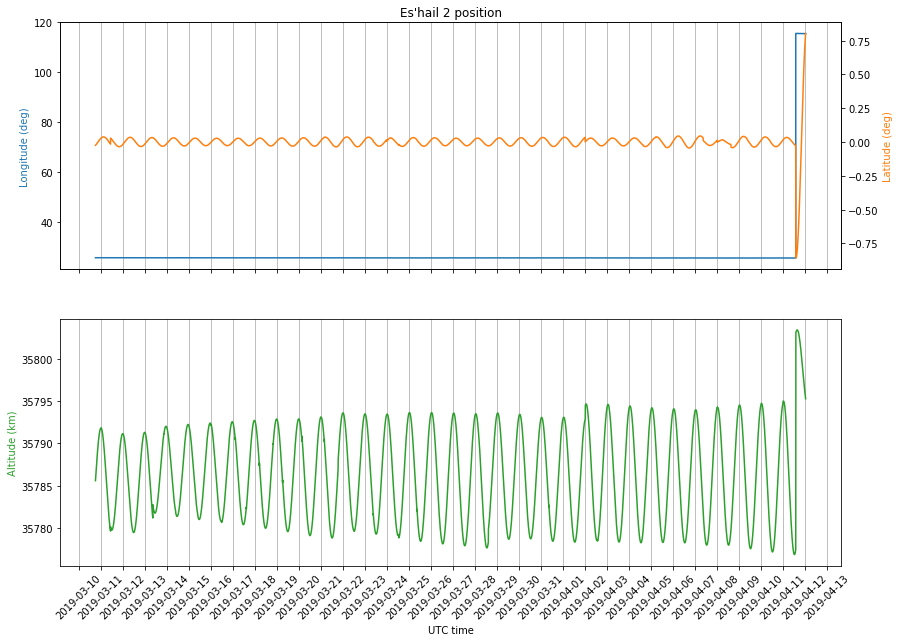

In [27]:
fig, axs = plt.subplots(2, figsize = (14, 10), facecolor = 'w')
ax1 = axs[0]
ax2 = ax1.twinx()
ax3 = axs[1]
ax1.plot(doppler_times, longitude, color = 'C0')
ax2.plot(doppler_times, latitude, color = 'C1')
ax3.plot(doppler_times, elevation, color = 'C2')
ax1.set_ylabel('Longitude (deg)', color = 'C0')
ax2.set_ylabel('Latitude (deg)', color = 'C1')
ax3.set_ylabel('Altitude (km)', color = 'C2')
ax1.set_title('Es\'hail 2 position')
for ax in axs:
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(''))
    ax.grid(axis = 'x')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.tick_params('x', rotation = 45)
ax3.set_xlabel('UTC time');